# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import api.constants as const
from api.NBADataImputer import NBADataImputer
from api.NBAInvestmentModel import NBAInvestmentModel
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import recall_score, confusion_matrix
from matplotlib import pyplot as plt

# EDA

### Load data

In [2]:
data = pd.read_csv(const.DEFAULT_DATA_PATH, dtype=const.DTYPES)
data.head()

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1


In [3]:
data.drop("Name", inplace=True, axis=1)
data.isna().sum()

GP              0
MIN             0
PTS             0
FGM             0
FGA             0
FG%             0
3P Made         0
3PA             0
3P%            11
FTM             0
FTA             0
FT%             0
OREB            0
DREB            0
REB             0
AST             0
STL             0
BLK             0
TOV             0
TARGET_5Yrs     0
dtype: int64

**Conclusion** 

This data is considered very clean, we can notice no null values except in 3P% which we could replace by 0. In fact, since not every NBA player is a 3P shooter, some player don't even have stats related to 3P because they never try and that's why it's wiser to fill it with 0 rather than the mean or the median.

In [4]:
data.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1329.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000
mean,60.414179,17.624627,6.801493,2.629104,5.885299,44.169403,0.247612,0.779179,19.308126,1.297687,1.821940,70.300299,1.009403,2.025746,3.034478,1.550522,0.618507,0.368582,1.193582,0.620149
std,17.433992,8.307964,4.357545,1.683555,3.593488,6.137679,0.383688,1.061847,16.022916,0.987246,1.322984,10.578479,0.777119,1.360008,2.057774,1.471169,0.409759,0.429049,0.722541,0.485531
min,11.000000,3.100000,0.700000,0.300000,0.800000,23.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.300000,0.000000,0.000000,0.000000,0.100000,0.000000
25%,47.000000,10.875000,3.700000,1.400000,3.300000,40.200000,0.000000,0.000000,0.000000,0.600000,0.900000,64.700000,0.400000,1.000000,1.500000,0.600000,0.300000,0.100000,0.700000,0.000000
50%,63.000000,16.100000,5.550000,2.100000,4.800000,44.100000,0.100000,0.300000,22.400000,1.000000,1.500000,71.250000,0.800000,1.700000,2.500000,1.100000,0.500000,0.200000,1.000000,1.000000
75%,77.000000,22.900000,8.800000,3.400000,7.500000,47.900000,0.400000,1.200000,32.500000,1.600000,2.300000,77.600000,1.400000,2.600000,4.000000,2.000000,0.800000,0.500000,1.500000,1.000000
max,82.000000,40.900000,28.200000,10.200000,19.800000,73.700000,2.300000,6.500000,100.000000,7.700000,10.200000,100.000000,5.300000,9.600000,13.900000,10.600000,2.500000,3.900000,4.400000,1.000000


### First analysis

<AxesSubplot:xlabel='TARGET_5Yrs', ylabel='count'>

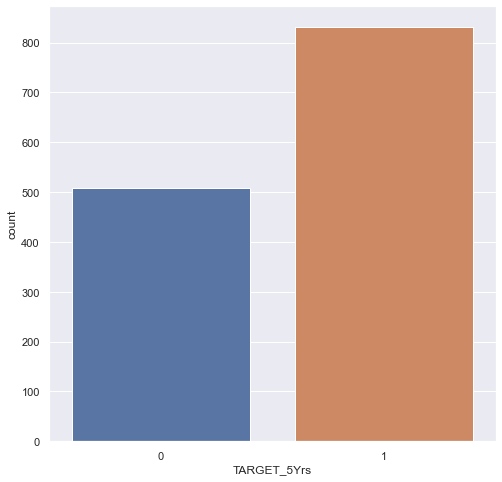

In [5]:
data.fillna(0, inplace=True)
sns.set(rc={'figure.figsize':(8,8)})
sns.countplot(x=const.TARGET_VARIABLE, data=data)

**Conclusion**

We're dealing with slightly umbalanced classes, therefore we could add weights in our catboost classifier.

<AxesSubplot:xlabel='AST', ylabel='Count'>

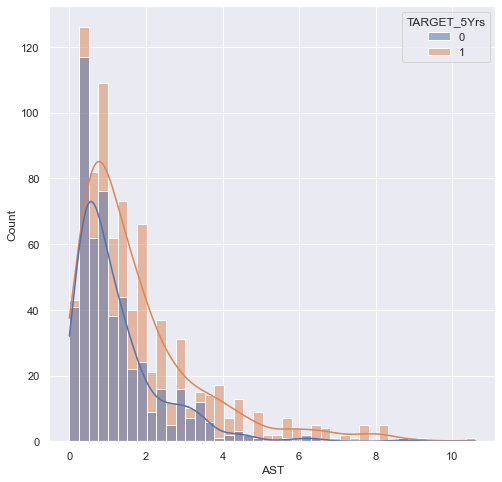

In [6]:
feature = np.random.choice(const.FEATURES_COLUMNS)
sns.set(rc={'figure.figsize':(8,8)})
sns.histplot(data=data, x=feature, hue=const.TARGET_VARIABLE, kde=True)

**Conclusion** 

This histplot studies the seperability of that feature based on target, for example, when it comes to GP we can notice a good seperability with target '1' mainly distributed in higher values of number of games played.
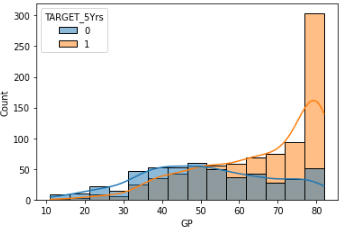

### Correlation

<AxesSubplot:>

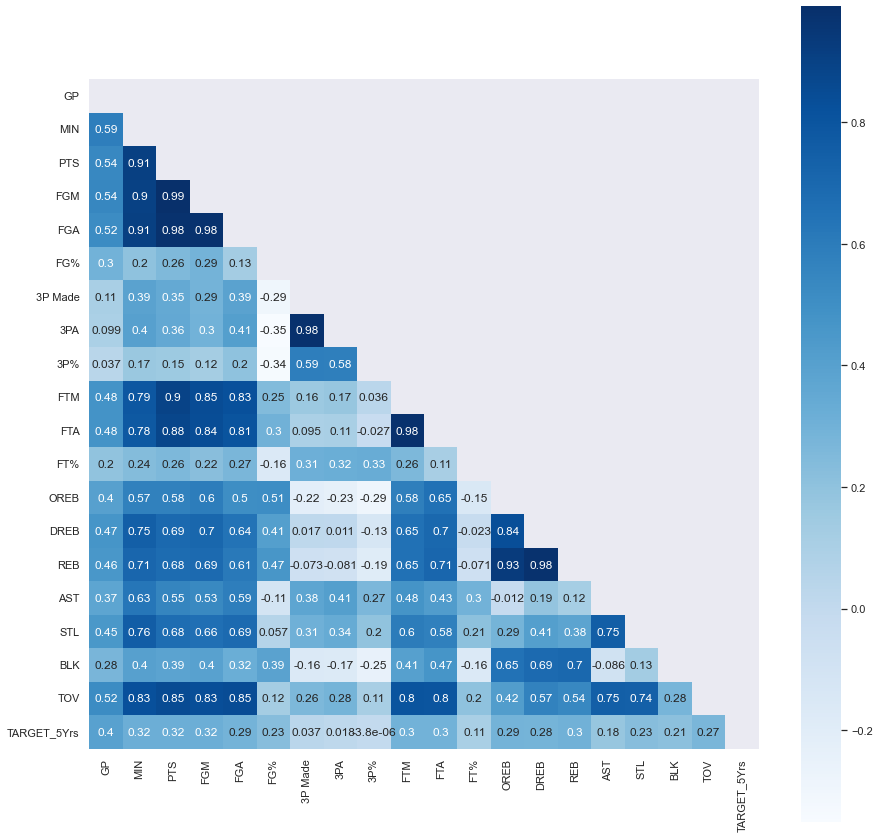

In [7]:
sns.set(rc={'figure.figsize':(15,15)})
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, square=True, annot=True, mask=mask, cmap='Blues')

**Conclusion** 

Correlation let us simplify the problem by removing highly correlated features and thus avoid overfitting problems. We notice that elements such as (MIN, PTS, FGM, FGA) or (3PA, 3P Made) are highly correlated due to the fact that they describe the same stat slightly differently (within a linear transformation). We can set a threshold (0.6) and keepee only one of highly correlated elements for our model later on.

# Modelisation

In the modelisation phase, we will use the object created which is NBATrainer that handles the data cleaning thanks to NBADataImputer and the grid search on different hyperparameters configurations over the model NBAInvestmentModel. Finally the trainer return best model and it helps predict the probability for a given new player to have a +5 years career in NBA.
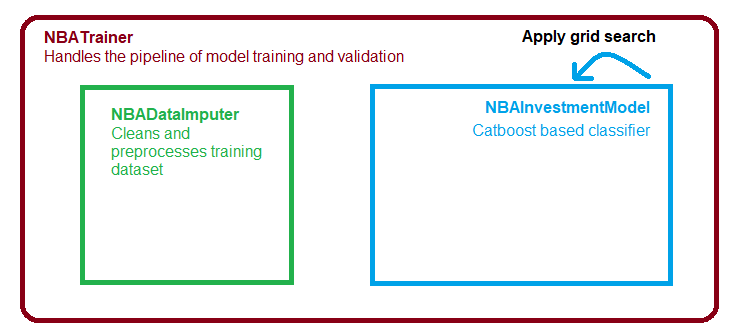

In [8]:
imputer = NBADataImputer(verbose_=True)
imputer.fit(data)
X_train, X_test, y_train, y_test = train_test_split(imputer.to_dict()["X"], imputer.to_dict()["y"], test_size=0.2)
model = NBAInvestmentModel(verbose_=True)
model.fit(X_train, y_train)

Start cleaning data, data size before processing is 1340
Finished cleaning data, data size after processing is 957
Finished loading model from C:\Users\Asus\Desktop\3A\CDI\Test\Test technique MP Data\catboost_models\nba_investment_catboost
Learning rate set to 0.014346
0:	learn: 0.6908861	test: 0.6919570	best: 0.6919570 (0)	total: 149ms	remaining: 12m 23s
1:	learn: 0.6891619	test: 0.6914617	best: 0.6914617 (1)	total: 150ms	remaining: 6m 14s
2:	learn: 0.6871660	test: 0.6900950	best: 0.6900950 (2)	total: 151ms	remaining: 4m 12s
3:	learn: 0.6850467	test: 0.6892094	best: 0.6892094 (3)	total: 153ms	remaining: 3m 10s
4:	learn: 0.6830590	test: 0.6882678	best: 0.6882678 (4)	total: 154ms	remaining: 2m 33s
5:	learn: 0.6808775	test: 0.6875217	best: 0.6875217 (5)	total: 156ms	remaining: 2m 9s
6:	learn: 0.6783649	test: 0.6861384	best: 0.6861384 (6)	total: 157ms	remaining: 1m 52s
7:	learn: 0.6757672	test: 0.6852617	best: 0.6852617 (7)	total: 159ms	remaining: 1m 39s
8:	learn: 0.6740366	test: 0.684596

142:	learn: 0.5781232	test: 0.6611990	best: 0.6605412 (133)	total: 313ms	remaining: 10.6s
143:	learn: 0.5777875	test: 0.6612845	best: 0.6605412 (133)	total: 314ms	remaining: 10.6s
144:	learn: 0.5775283	test: 0.6613219	best: 0.6605412 (133)	total: 316ms	remaining: 10.6s
145:	learn: 0.5772704	test: 0.6611687	best: 0.6605412 (133)	total: 317ms	remaining: 10.5s
146:	learn: 0.5769260	test: 0.6614693	best: 0.6605412 (133)	total: 318ms	remaining: 10.5s
147:	learn: 0.5766934	test: 0.6615759	best: 0.6605412 (133)	total: 319ms	remaining: 10.5s
148:	learn: 0.5762131	test: 0.6612664	best: 0.6605412 (133)	total: 320ms	remaining: 10.4s
149:	learn: 0.5756239	test: 0.6612358	best: 0.6605412 (133)	total: 321ms	remaining: 10.4s
150:	learn: 0.5754577	test: 0.6615128	best: 0.6605412 (133)	total: 322ms	remaining: 10.3s
151:	learn: 0.5752310	test: 0.6615449	best: 0.6605412 (133)	total: 323ms	remaining: 10.3s
152:	learn: 0.5750191	test: 0.6613708	best: 0.6605412 (133)	total: 325ms	remaining: 10.3s
153:	learn

# Evaluation

### Recall score SKLearn

Recall score using 3-Folds method is 0.7159763313609467


<AxesSubplot:>

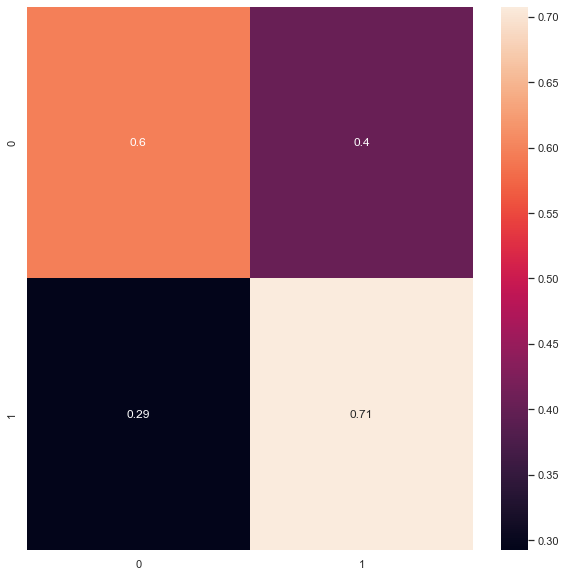

In [9]:
n_splits = 3
kf = KFold(n_splits=n_splits,random_state=50,shuffle=True)
model = NBAInvestmentModel(verbose_=False)
imputer = NBADataImputer(verbose_=False)
imputer.fit(data)
confusion_mat = np.zeros((2,2))
score = 0
for training_ids,test_ids in kf.split(imputer.to_dict()["X"]):
    X_train = imputer.to_dict()["X"].loc[training_ids]
    y_train = imputer.to_dict()["y"].loc[training_ids]
    X_test = imputer.to_dict()["X"].loc[test_ids]
    y_test = imputer.to_dict()["y"].loc[test_ids][const.TARGET_VARIABLE].values
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    confusion_mat+=confusion_matrix(y_test, y_pred, normalize='true')
    score += recall_score(y_test, y_pred)
score /= n_splits
confusion_mat /= n_splits

print("Recall score using {}-Folds method is {}".format(n_splits, recall_score(y_test, y_pred)))
sns.set(rc={'figure.figsize':(10,10)})
sns.heatmap(confusion_mat, annot=True)

**Conclusion** 

In this problem we will be interested in the given recall metric based on KFold resampling technique because our dataset is small (1340 rows only) therefore, testing the model after one single fit over (70-80% of data) is not enough to conclude over its efficiency. However, KFold attempts to train the model multiple times to converge slowly towards the real recall score of the data distribution. We could use Bootstrap resampling technique as well (with replacement) and use higher K (not just 3 folds).

From a business point of View, investors care mainly about false positive rate (FPR) with the following formula 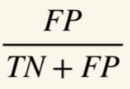 Because investing on a player that wouldn't have a +5 years career is far worse than missing a player that would have a +5 years career, in the first case the investor loses money and in the latter, he loses an opportunity to make money. So minimizing the FPR is the main goal of investors in this usecase.

### Explainability

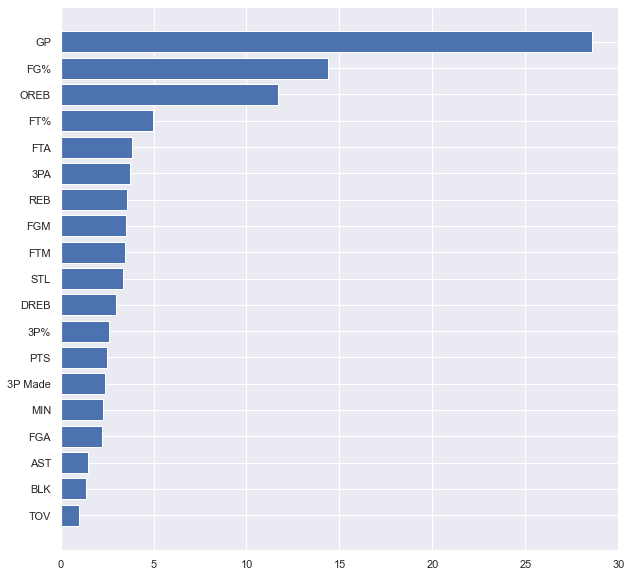

In [10]:
#get feature importance of catboost model
feature_importance = model.model.get_feature_importance()
features = const.FEATURES_COLUMNS
#sort features by their feature importance score
zipped = sorted(zip(feature_importance, features))
feature_importance = [x[0] for x in zipped]
features = [x[1] for x in zipped]
#plot feature importance in a horizental bar plot
y_pos = np.arange(len(features))
plt.barh(y_pos, feature_importance)
plt.yticks(y_pos, features)
plt.show()

**Conclusion** 

Based on the plot of feature importance, we notice that the number of games played is the most important feature to decide whether a player would or not have a +5 years career with a weight of about 30%. This may seem coherent because the more a player have games the higher he had or would have a +5 years career. However, from an investment point of vue, investors would prefer a player who could go for 5 years and plus and not necessarily someone who have had already 5 years of career and therfore the second most important feature which is the precentage of field goals per game seems more relevant, because the higher the percentage, the better the player is and the higher his chances are to be picked by talent hunters to join top tier NBA teams and have a long career. 